# U - Net
## Problem: 

Seismic data is collected using reflection seismology, or seismic reflection. The method requires a controlled seismic source of energy, such as compressed air or a seismic vibrator, and sensors record the reflection from rock interfaces within the subsurface. The recorded data is then processed to create a 3D view of earth’s interior. Reflection seismology is similar to X-ray, sonar and echolocation.

A seismic image is produced from imaging the reflection coming from rock boundaries. The seismic image shows the boundaries between different rock types. In theory, the strength of reflection is directly proportional to the difference in the physical properties on either sides of the interface. While seismic images show rock boundaries, they don't say much about the rock themselves; some rocks are easy to identify while some are difficult.

There are several areas of the world where there are vast quantities of salt in the subsurface. One of the challenges of seismic imaging is to identify the part of subsurface which is salt. Salt has characteristics that makes it both simple and hard to identify. Salt density is usually 2.14 g/cc which is lower than most surrounding rocks. The seismic velocity of salt is 4.5 km/sec, which is usually faster than its surrounding rocks. This difference creates a sharp reflection at the salt-sediment interface. Usually salt is an amorphous rock without much internal structure. This means that there is typically not much reflectivity inside the salt, unless there are sediments trapped inside it. The unusually high seismic velocity of salt can create problems with seismic imaging.

### Data
The data is a set of images chosen at various locations chosen at random in the subsurface. The images are 101 x 101 pixels and each pixel is classified as either salt or sediment. In addition to the seismic images, the depth of the imaged location is provided for each image. The goal of the competition is to segment regions that contain salt.

#### Source: 
https://www.kaggle.com/c/tgs-salt-identification-challenge


### Note: 
Accept the terms and download data from the above link

### Aim: 

Implement U-Net neural model architecture in keras to solve this problem.


In this, you are asked to segment salt deposits beneath the Earth’s surface. Given a set of seismic images that are 101 x 101 pixels each and each pixel we need to classify as either salt or sediment. Our goal is to segment regions that contain salt. A seismic image is produced from imaging the reflection coming from rock boundaries. The seismic image shows the boundaries between different rock types. 

### Broad Steps:

1. Download the dataset
2. Upload to Drive
3. Import from drive to colab
4. Load the images and create training data.
5. Build U-net Model
6. Train your model.
7. Check the validation accuracy and plot sample.

In [0]:
#Importing necessary libraries
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [153]:
#Mount drive
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


### 1.Set your project path where you have your data and related files for this lab.

In [0]:
import os
os.chdir('/content/drive/My Drive/Advanced_Computer_vision/External_lab')
project_path = '.'

### 2. Set the necessary parameters

## Setup

In [0]:
im_width = 128      #width of your train image
im_height = 128     #hight of your train image
#border =  
path_train = project_path + 'train/'   
path_test = project_path + 'test/'   

# 3. Make directory for train data at in your project/lab folder.

Hint - use !mkdir function.

In [0]:
os.mkdir(path_train)

# 4. Extract your train images to the train directory you have just created above. 
train.zip and test.zip files available at your google drive/local system.

As a good practice - Upload or copy the data at your project path folder.

Make sure you are providing the right project_path.

In [0]:
#For simplicity we have added the required code here.
from zipfile import ZipFile

with ZipFile('/content/drive/My Drive/Advanced_Computer_vision/External_lab/train.zip', 'r') as zf:
  zf.extractall('train/')


### 5. Get the list of names of images and masks and name the list imagelist and masklist.

Hint - Use os.listdir() funtions.

In [0]:
imagelist  = os.listdir('/content/drive/My Drive/Advanced_Computer_vision/External_lab/train/images/')
masklist  = os.listdir('/content/drive/My Drive/Advanced_Computer_vision/External_lab/train/masks/')

In [159]:
len(imagelist)

4000

In [160]:
len(masklist)

4000

In [0]:
#Test your list names by printing some of the names as given below.
print(imagelist[-1])
print(masklist[-1])
print(imagelist[10])
print(masklist[10])

7cc53fe88b.png
7cc53fe88b.png
de08c5a3b7.png
de08c5a3b7.png


# 6. Read and test your images and respective masks.

Hint -

import  matplotlib.pyplot as plt

import cv2

plt.imshow(cv2.imread('path of image'))

plt.imshow(cv2.imread('path of mask'))


In [0]:
import cv2
import matplotlib.pyplot as plt

In [0]:
ids = [imagelist[-1], imagelist[10], imagelist[20],imagelist[30],imagelist[40],]
i_path = '/content/drive/My Drive/Advanced_Computer_vision/External_lab/train/images/'
m_path = '/content/drive/My Drive/Advanced_Computer_vision/External_lab/train/masks/'

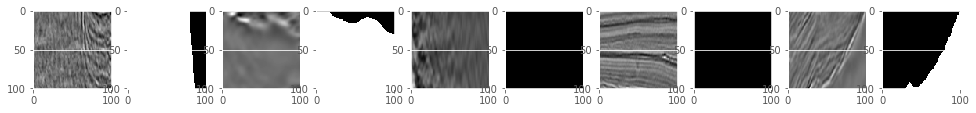

In [163]:
plt.figure(figsize=(20,10))
for j, img_name in enumerate(ids):
    q = j+1
    img = load_img(i_path + img_name )
    img_mask = load_img(m_path + img_name )
    
    plt.subplot(1,2*(1+len(ids)),q*2-1)
    plt.imshow(img)
    plt.subplot(1,2*(1+len(ids)),q*2)
    plt.imshow(img_mask)
plt.show()

# 7. Create your training data.

Hints - 

image_path = os.path.join(project_path +'path of your image directory' +n )

mask_path = os.path.join(project_path +'path of your mask directory'+n )

In [0]:
# Get and resize train images and masks
def get_data():
    X = np.zeros(((len(imagelist), im_height, im_width, 1)), dtype=np.float32) # Create an array for image
    y = np.zeros(((len(masklist), im_height, im_width, 1)), dtype=np.float32) #Create an array for mask
    
    for n in imagelist: 
        k = imagelist.index(n)
        ##Add image_path
        image_path =   os.path.join(i_path, n)
        ##Add mask_path
        mask_path =    os.path.join(m_path, n)                                                        
        
        # Load images and resize to (128,128,1)
        img = load_img(image_path)
        x = img_to_array(img)[:,:,1]
        resized_img = resize(x, (128, 128, 1), mode='constant', preserve_range=True)

        # Load masks and resize to (128,128,1)
        mask = load_img(mask_path)
        m = img_to_array(mask)[:,:,1]
        resized_mask = resize(m, (128, 128, 1), mode='constant', preserve_range=True)
        # Save images
        X[k, ..., 0] = resized_img.squeeze() / 255
        y[k] = resized_mask
        return X, y
X, y = get_data()

In [165]:
print("shape of X:", X.shape)
print("shape of y:", y.shape)

shape of X: (4000, 128, 128, 1)
shape of y: (4000, 128, 128, 1)


In [0]:
# Split train and valid
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.15, random_state=2019)

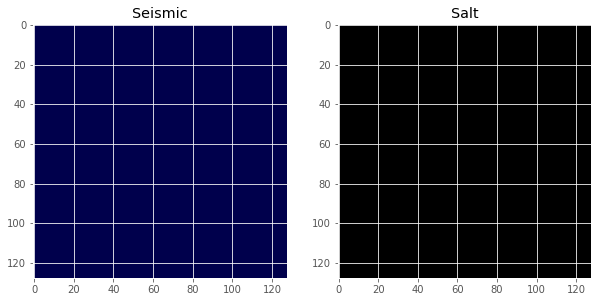

In [167]:
## Test your data whether it looks fine - Random check
import random 
# Check if training data looks all right
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0

fig, ax = plt.subplots(1, 2, figsize=(10, 10))

ax[0].imshow(X_train[ix, ..., 0], cmap='seismic', interpolation='bilinear')
if has_mask:
    ax[0].contour(y_train[ix].squeeze(), colors='k', levels=[0.5])
ax[0].set_title('Seismic')

ax[1].imshow(y_train[ix].squeeze(), interpolation='bilinear', cmap='gray')
ax[1].set_title('Salt');

## 8. Define loss and dice_coeff function.



In [0]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tf.keras.backend.epsilon())

In [0]:
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - tf.log(dice_coefficient(y_true, y_pred) + tf.keras.backend.epsilon())

### 9. Build and compile UNet Model for your data.

Hint - 
You can install and use segmentation models from this github repository.

#Install segmentation models

!pip install git+https://github.com/qubvel/segmentation_models

In [0]:
!pip install git+https://github.com/qubvel/segmentation_models

  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-3cciczrj
  Running command git clone -q https://github.com/qubvel/segmentation_models /tmp/pip-req-build-3cciczrj
  Running command git submodule update --init --recursive -q
  Created wheel for segmentation-models: filename=segmentation_models-1.0.1-cp36-none-any.whl size=33587 sha256=c67355717e7ab17e4737e6a445c0b10c69af9504f24bf27bace7a3faf3b7c150
  Stored in directory: /tmp/pip-ephem-wheel-cache-wu127620/wheels/49/cf/46/cbb4bb64518c402aea99df9d466f1081450597e653256bbcf4
Successfully built segmentation-models


In [0]:
from segmentation_models import Unet
from keras.losses import binary_crossentropy
model = Unet(backbone_name='resnet34', encoder_weights=None, input_shape=(None, None, 1))
# compile your model by adding the parameters like optimizer, loss and metrics.

model.compile(optimizer='Adam', loss=loss, metrics=[dice_coefficient])


In [171]:
#Get the summary of your model
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, None, None, 1 0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, None, None, 1 3           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_69 (ZeroPadding2 (None, None, None, 1 0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, None, None, 6 3136        zero_padding2d_69[0][0]          
____________________________________________________________________________________________

### 10. Fit your model using model.fit function.
Hint - As it might take long time to run. Run it for only 1 or 2 epochs.

In [172]:
model.fit(
    x=X_train,
    y=y_train,
    batch_size=50,    
    epochs=2,
    validation_data=(X_valid, y_valid))

Train on 3400 samples, validate on 600 samples
Epoch 1/2
3400/3400 [==============================] - 1233s 363ms/step - loss: 16.1930 - dice_coefficient: 0.0132 - val_loss: 16.2179 - val_dice_coefficient: 0.0000e+00
Epoch 2/2
3400/3400 [==============================] - 1231s 362ms/step - loss: 16.0768 - dice_coefficient: 0.0017 - val_loss: 16.1558 - val_dice_coefficient: 0.0000e+00


### 11.Predict on val set using model.predict funtion and store in preds_val variable.



In [173]:
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

600/600 [==============================] - 52s 86ms/step


In [0]:
#Get the threshold predictions to look at refined results.
preds_val_t = (preds_val > 0.5).astype(np.uint8)

In [0]:
#Plot a sample
def plot_sample(X, y, preds, binary_preds, ix=None):
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Seismic')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Salt')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Salt Predicted')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Salt Predicted binary');

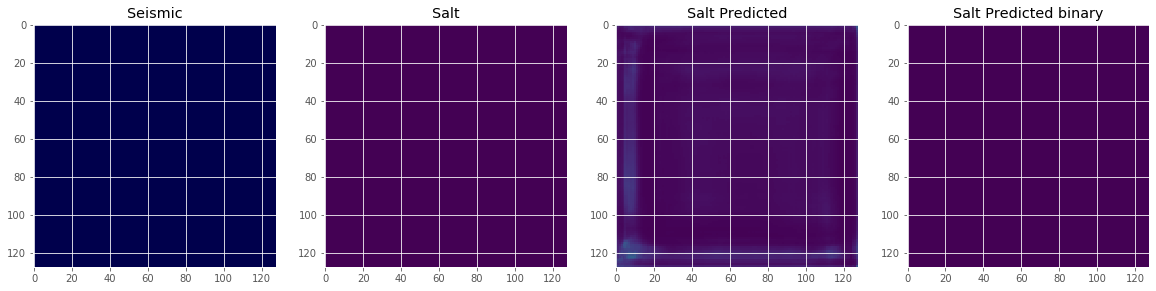

In [176]:
# Check if valid data looks all right
plot_sample(X_valid, y_valid, preds_val, preds_val_t, ix=15)

If you are getting good results- Congratulations.
If you are not, try to explore what might be the reason.